## Used packages

In [56]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [57]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator

## Creating samples LHC

In [58]:
# ema_logging.log_to_stderr(ema_logging.INFO)

# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(3)

to only focus on the scenarios no policies should be taken into account. Code below set all the 

In [59]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [60]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=2000,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results


100%|██████████████████████████████████████| 2000/2000 [03:56<00:00,  8.47it/s]


In [61]:
experiments_unc =experiments.iloc[:,0:19]

In [62]:
outcomes.keys()

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [63]:
df = pd.DataFrame(outcomes) 
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

In [64]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [65]:
outcomes_feaimp = outcomes

In [66]:
df_feature_importance_out = df[["Total Costs", "Expected Number of Deaths","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

 12%|████▋                                  | 12/100 [16:16<1:59:22, 81.40s/it]


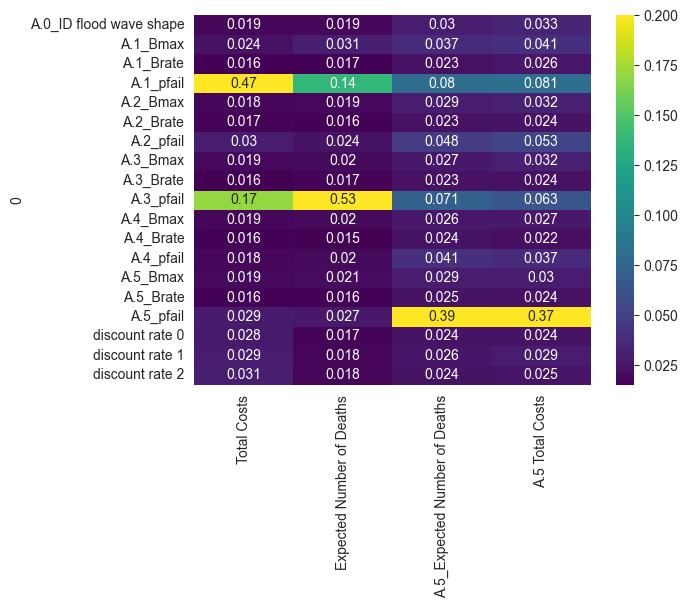

In [67]:
x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,vmax=0.2)
plt.show()

In [68]:
for x  in dike_model.uncertainties:
    print(x)

discount rate 0
discount rate 1
discount rate 2
A.0_ID flood wave shape
A.1_Bmax
A.1_pfail
A.1_Brate
A.2_Bmax
A.2_pfail
A.2_Brate
A.3_Bmax
A.3_pfail
A.3_Brate
A.4_Bmax
A.4_pfail
A.4_Brate
A.5_Bmax
A.5_pfail
A.5_Brate


In [69]:
print(repr(dike_model.uncertainties))

In [70]:
dike_model.uncertainties[0].name

'discount rate 0'

In [71]:
new_uncertainties = []
for index,x  in enumerate(dike_model.uncertainties):
    # print()
    if dike_model.uncertainties[index].name in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail"]:
        print(repr(x))
        new_uncertainties.append(x)

RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfail'], pff=False)
RealParameter('A.4_pfail', 0, 1, resolution=None, default=None, variable_name=['A.4_pfail'], pff=False)
RealParameter('A.5_pfail', 0, 1, resolution=None, default=None, variable_name=['A.5_pfail'], pff=False)


In [72]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)
print()

In [73]:
dele = []
for x in dike_model_1.uncertainties:
    print(x.name)
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail"]:
        dele.append(x.name)
    else
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)

discount rate 0
discount rate 1
discount rate 2
A.0_ID flood wave shape
A.1_Bmax
A.1_pfail
A.1_Brate
A.2_Bmax
A.2_pfail
A.2_Brate
A.3_Bmax
A.3_pfail
A.3_Brate
A.4_Bmax
A.4_pfail
A.4_Brate
A.5_Bmax
A.5_pfail
A.5_Brate


In [74]:
list(dike_model_1.uncertainties)

[RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False),
 RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False),
 RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfail'], pff=False),
 RealParameter('A.4_pfail', 0, 1, resolution=None, default=None, variable_name=['A.4_pfail'], pff=False),
 RealParameter('A.5_pfail', 0, 1, resolution=None, default=None, variable_name=['A.5_pfail'], pff=False)]

In [75]:
dike_model_1.uncertainties.keys()

odict_keys(['A.1_pfail', 'A.2_pfail', 'A.3_pfail', 'A.4_pfail', 'A.5_pfail'])

In [76]:
help(type( dike_model_1.uncertainties ))

Help on class NamedObjectMap in module ema_workbench.em_framework.util:

class NamedObjectMap(builtins.object)
 |  NamedObjectMap(kind)
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value)
 |  
 |  __contains__(self, item)
 |  
 |  __delitem__(self, key)
 |  
 |  __getitem__(self, key)
 |  
 |  __iadd__(self, value)
 |  
 |  __init__(self, kind)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __len__(self)
 |  
 |  __setitem__(self, key, value)
 |  
 |  clear(self)
 |  
 |  copy(self)
 |  
 |  extend(self, value)
 |  
 |  keys(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __slotnames__ = []


In [77]:
list(dike_model_1.uncertainties)

[RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False),
 RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False),
 RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfail'], pff=False),
 RealParameter('A.4_pfail', 0, 1, resolution=None, default=None, variable_name=['A.4_pfail'], pff=False),
 RealParameter('A.5_pfail', 0, 1, resolution=None, default=None, variable_name=['A.5_pfail'], pff=False)]

In [78]:
# dike_model.uncertainties = new_uncertainties[0]

In [79]:
[print(x) for x in dike_model_1.uncertainties]

A.1_pfail
A.2_pfail
A.3_pfail
A.4_pfail
A.5_pfail


[None, None, None, None, None]

In [80]:
with SequentialEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=100,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

  0%|                                                  | 0/100 [00:00<?, ?it/s]'ID flood wave shape'
Traceback (most recent call last):
  File "C:\Users\roelo\src\ema-workbench\ema_workbench\em_framework\experiment_runner.py", line 92, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\roelo\src\ema-workbench\ema_workbench\util\ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\roelo\src\ema-workbench\ema_workbench\em_framework\model.py", line 347, in run_model
    outputs = self.run_experiment(experiment)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\roelo\src\ema-workbench\ema_workbench\util\ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\roelo\src\ema-workbench\ema_workbench\em_framework\model.py", line 400, in run_experiment
    model_output = self.function(**experiment)
                   ^^^^^^^^^^^^^^^^^

EMAError: Exception in run_model
Caused by: KeyError: 'ID flood wave shape'

In [ ]:
outcomes_feaimp = outcomes


In [ ]:
experiments_unc =experiments.iloc[:,0:18]

In [ ]:
df =pd.DataFrame(outcomes)

In [ ]:
experiments_unc

In [ ]:
df_feature_importance_out = df[
    ["A.5_Expected Number of Deaths", "A.5 Total Costs"]]

x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, vmax=0.2)
plt.show()

In [ ]:
import pandas as pd

In [ ]:
df =pd.DataFrame(outcomes)

In [ ]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [ ]:
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

In [ ]:
Si = sobol.analyze(problem, outcomes["A.5 Total Costs"], calc_second_order=True, print_to_console=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
Si = sobol.analyze(problem, outcomes["A.5_Expected Number of Deaths"], calc_second_order=True, print_to_console=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()